In [1]:
using Turing
using LimberJack
using CSV
using NPZ
using Plots
using FITSIO
using Plots
using LinearAlgebra
using Distributed
using StatsPlots
using Optim
using ForwardDiff
using BenchmarkTools
using DelimitedFiles

In [2]:
files = npzread("../data/DESY1_cls/Cls_meta.npz")
Cls_meta = cls_meta(files)

cls_meta{Vector{Vector{Int64}}}([[1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [2, 0], [2, 1], [2, 2], [2, 3]], [[1, 0, 1, 0], [1, 1, 1, 1], [1, 2, 1, 2], [1, 3, 1, 3], [1, 4, 1, 4], [1, 0, 2, 0], [1, 0, 2, 1], [1, 0, 2, 2], [1, 0, 2, 3], [1, 1, 2, 0]  …  [2, 0, 2, 0], [2, 0, 2, 1], [2, 0, 2, 2], [2, 0, 2, 3], [2, 1, 2, 1], [2, 1, 2, 2], [2, 1, 2, 3], [2, 2, 2, 2], [2, 2, 2, 3], [2, 3, 2, 3]], [[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [1, 6], [1, 7], [1, 8], [1, 9], [2, 6]  …  [6, 6], [6, 7], [6, 8], [6, 9], [7, 7], [7, 8], [7, 9], [8, 8], [8, 9], [9, 9]])

In [3]:
cov_tot = files["cov"]
inv_cov_tot = files["inv_cov"]
data_vector = files["cls"];

In [4]:
#                Omega_b,           Omega_c          n_s,                 h,
#                DESgc__0_gc_b,     DESgc__1_gc_b,   DESgc__2_gc_b,    DESgc__3_gc_b,    DESgc__4_gc_b,
#                DESgc__0_dz,      DESgc__1_dz,      DESgc__2_dz,      DESgc__3_dz,      DESgc__4_dz,
#                wl_ia_A,          wl_ia_eta, 
#                DESwl__0_wl_m,    DESwl__1_wl_m,    DESwl__2_wl_m,    DESwl__3_wl_m,
#                DESwl__0_dz,      DESwl__1_dz,      DESwl__2_dz,      DESwl__3_dz,
#                sigma_8,          Omega_m
carlos_params1 = [4.426868e-02,     2.093138e-01,     8.963611e-01,     8.495440e-01,
                 1.343888e+00,    1.639047e+00,      1.597174e+00,     1.944583e+00,     2.007245e+00,
                -4.679383e-03,   -2.839996e-03,      1.771571e-03,     1.197051e-03,    -5.199799e-03,
                 2.389208e-01,   -6.435288e-01, 
                 1.802722e-03,   -5.508994e-03,     1.952514e-02,    -1.117726e-03,
                -1.744083e-02,    6.777779e-03,    -1.097939e-03,    -4.912315e-03,
                 8.536883e-01,    2.535825e-01];

In [5]:
cls_carlos = npzread("/home/jaime/PhD/LimberJack.jl/chains/cl_cross_corr_v3_DES_2/cl_cross_corr_bestfit_info.npz");
cls_carlos2 = npzread("/home/jaime/PhD/LimberJack.jl/chains/cl_cross_corr_v3_DES_2/cl_cross_corr_bestfit_info_nointerp.npz");
cls_carlos3 = npzread("/home/jaime/PhD/LimberJack.jl/chains/cl_cross_corr_v3_DES_2/cl_cross_corr_bestfit_info_nointerp_EH.npz");
cls_carlos4 = npzread("/home/jaime/PhD/LimberJack.jl/chains/cl_cross_corr_v3_DES_2/cl_cross_corr_bestfit_info_nointerp_EH_noconv.npz");

In [6]:
pars = carlos_params1
nuisances = Dict("b0" => pars[5],
                 "b1" => pars[6],
                 "b2" => pars[7],
                 "b3" => pars[8],
                 "b4" => pars[9],
                 "dz_g0" => pars[10],
                 "dz_g1" => pars[11],
                 "dz_g2" => pars[12],
                 "dz_g3" => pars[13],
                 "dz_g4" => pars[14],
                 "dz_k0" => pars[21],
                 "dz_k1" => pars[22],
                 "dz_k2" => pars[23],
                 "dz_k3" => pars[24],
                 "m0" => pars[17],
                 "m1" => pars[18],
                 "m2" => pars[19],
                 "m3" => pars[20],
                 "A_IA" => pars[15],
                 "alpha_IA" => pars[16]);

In [7]:
function make_cls(pars; mode="linear")
    nuisances = Dict("b0" => pars[5],
                     "b1" => pars[6],
                     "b2" => pars[7],
                     "b3" => pars[8],
                     "b4" => pars[9],
                     "dz_g0" => pars[10],
                     "dz_g1" => pars[11],
                     "dz_g2" => pars[12],
                     "dz_g3" => pars[13],
                     "dz_g4" => pars[14],
                     "dz_k0" => pars[21],
                     "dz_k1" => pars[22],
                     "dz_k2" => pars[23],
                     "dz_k3" => pars[24],
                     "m0" => pars[17],
                     "m1" => pars[18],
                     "m2" => pars[19],
                     "m3" => pars[20],
                     "A_IA" => pars[15],
                     "alpha_IA" => pars[16])

    Ωm = pars[26]
    Ωb = pars[1]
    h = pars[4]
    ns = pars[3]
    s8 = pars[25]
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8, 
                                     tk_mode="EisHu", Pk_mode="Halofit", 
                                     nk=1000, nz=1000, nz_pk=1000)
    
    if mode=="linear"
        cls =Theory(cosmology, nuisances, Cls_meta, files)
    else
        cls = Theory_parallel(cosmology, nuisances, Cls_meta, files)
    end
    
    return cls
end

make_cls (generic function with 1 method)

In [32]:
make_cls(carlos_params1, mode="linear")
#@time [make_cls(carlos_params1, mode="linear") for i in 1:10]

475-element Vector{Float64}:
 0.00019837136534049275
 8.11582026351179e-5
 4.148574028050863e-5
 2.6008248735334005e-5
 1.8076299632671127e-5
 0.00011296356608226019
 6.0808357916455044e-5
 3.885997520734355e-5
 2.410850210839154e-5
 1.7414073123610228e-5
 1.2800367977783066e-5
 1.0098338330485099e-5
 8.181700406338805e-6
 ⋮
 7.447619824602188e-10
 6.394340789452654e-10
 5.4940048597619e-10
 4.722593656716336e-10
 4.056249522665224e-10
 3.478221480417219e-10
 2.9754946947417937e-10
 2.5359345840470615e-10
 2.151980100314464e-10
 1.8171605619904265e-10
 1.5256985638486738e-10
 1.2734450995232054e-10

In [33]:
make_cls(carlos_params1, mode="parallel")
#@time [make_cls(carlos_params1, mode="parallel") for i in 1:10]

475-element Vector{Float64}:
 0.00019837136534049275
 8.11582026351179e-5
 4.148574028050863e-5
 2.6008248735334005e-5
 1.8076299632671127e-5
 0.00011296356608226019
 6.0808357916455044e-5
 3.885997520734355e-5
 2.410850210839154e-5
 1.7414073123610228e-5
 1.2800367977783066e-5
 1.0098338330485099e-5
 8.181700406338805e-6
 ⋮
 7.447619824602188e-10
 6.394340789452654e-10
 5.4940048597619e-10
 4.722593656716336e-10
 4.056249522665224e-10
 3.478221480417219e-10
 2.9754946947417937e-10
 2.5359345840470615e-10
 2.151980100314464e-10
 1.8171605619904265e-10
 1.5256985638486738e-10
 1.2734450995232054e-10

In [34]:
function diff_cls_linear(Ωm)
    cosmology = LimberJack.Cosmology(Ωm, 0.05, 0.67, 0.96, 0.81, tk_mode="EisHu", Pk_mode="Halofit")
    cls = Theory(cosmology, nuisances, Cls_meta, files)
    return cls
end

function diff_cls_parallel(Ωm)
    cosmology = LimberJack.Cosmology(Ωm, 0.05, 0.67, 0.96, 0.81, tk_mode="EisHu", Pk_mode="Halofit")
    return Theory_parallel(cosmology, nuisances, Cls_meta, files)
end

diff_cls_parallel (generic function with 1 method)

In [35]:
ForwardDiff.derivative(diff_cls_linear, 0.30)
#@time [ForwardDiff.derivative(diff_cls_linear, 0.30) for i in 1:10]

475-element Vector{Float64}:
 -0.0009849601699735311
 -0.00015955047222590584
 -1.9939237630606314e-5
 -2.341151034040552e-6
 -1.2744074707069619e-6
 -0.0006811785513783999
 -0.00015346912594387907
 -7.248782511480169e-5
 -1.2245914263325083e-5
 -3.937788973917871e-6
  1.1028915728409853e-6
 -8.52683231175496e-7
  1.2919950413543852e-6
  ⋮
  3.9810269202328085e-9
  3.440878682385327e-9
  2.97886361933099e-9
  2.5823334899347646e-9
  2.2375845981183373e-9
  1.933226115059866e-9
  1.6695745186828993e-9
  1.4354040329593244e-9
  1.2278888465452742e-9
  1.0457993700752026e-9
  8.848326834932572e-10
  7.428732568523111e-10

In [12]:
ForwardDiff.derivative(diff_cls_parallel, 0.30)
#@time [ForwardDiff.derivative(diff_cls_parallel, 0.30) for i in 1:10]

475-element Vector{Float64}:
 -0.0009849601699735311
 -0.00015955047222590584
 -1.9939237630606314e-5
 -2.341151034040552e-6
 -1.2744074707069619e-6
 -0.0006811785513783999
 -0.00015346912594387907
 -7.248782511480169e-5
 -1.2245914263325083e-5
 -3.937788973917871e-6
  1.1028915728409853e-6
 -8.52683231175496e-7
  1.2919950413543852e-6
  ⋮
  3.9810269202328085e-9
  3.440878682385327e-9
  2.97886361933099e-9
  2.5823334899347646e-9
  2.2375845981183373e-9
  1.933226115059866e-9
  1.6695745186828993e-9
  1.4354040329593244e-9
  1.2278888465452742e-9
  1.0457993700752026e-9
  8.848326834932572e-10
  7.428732568523111e-10

In [8]:
cls_jaime1 = make_cls(carlos_params1, mode="linear")
cls_jaime2 = make_cls(carlos_params1, mode="parallel");

In [9]:
open("jaime_cls.txt", "w") do io
       writedlm(io, cls_jaime1)
end

In [10]:
compa1 = @. abs(cls_carlos["cls"]-cls_jaime1)/cls_carlos["cls"];
compa2 = @. abs(cls_carlos2["cls"]-cls_jaime1)/cls_carlos2["cls"];
compa3 = @. abs(cls_carlos3["cls"]-cls_jaime1)/cls_carlos3["cls"];
compa4 = @. abs(cls_carlos4["cls"]-cls_jaime1)/cls_carlos4["cls"];

println("Mean discrepancy default   ", mean(compa1))
println("Mean discrepancy no itp    ", mean(compa2))
println("Mean discrepancy no itp+EH ", mean(compa3))
println("Mean discrepancy no itp+EH+noconv ", mean(compa4))

Mean discrepancy default   0.019499946602408294
Mean discrepancy no itp    0.01610636066670292
Mean discrepancy no itp+EH 0.009751555009931863
Mean discrepancy no itp+EH+noconv 0.005052930965172868


In [11]:
chi2_carlos = cls_carlos["chi2_nolp"]
chi2_carlos2 = cls_carlos2["chi2_nolp"]
chi2_carlos3 = cls_carlos3["chi2_nolp"]
chi2_carlos4 = cls_carlos4["chi2_nolp"]
println(chi2_carlos)
println(chi2_carlos2)
println(chi2_carlos3)
println(chi2_carlos4)

495.62231927779936
495.00947244084654
495.89420547809317
497.2051355000593


In [12]:
chi2_jaime1 = dot((cls_jaime1 .- data_vector), inv_cov_tot  * (cls_jaime1 .- data_vector))
chi2_jaime2 = dot((cls_jaime2 .- data_vector), inv_cov_tot  * (cls_jaime2 .- data_vector))
println(chi2_jaime1)
println(chi2_jaime2)

498.0905732368873
498.0905732368873


In [13]:
(chi2_jaime1-chi2_carlos4)/chi2_carlos4

0.0017808298297993892

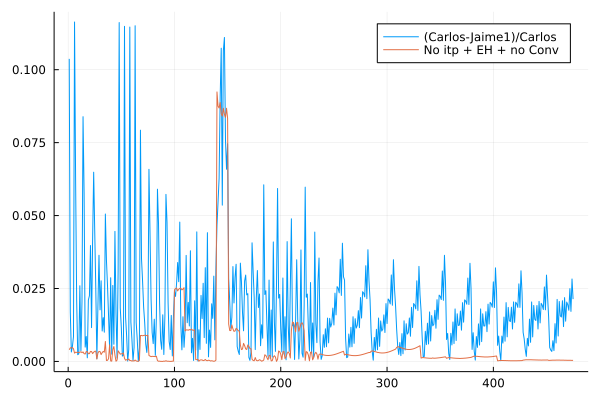

In [14]:
plot(compa1, label="(Carlos-Jaime1)/Carlos")
plot!(compa4, label="No itp + EH + no Conv")

In [13]:
@model function model(data_vector::Vector{Float64})
    Ωm ~ Uniform(0.1, 0.5)
    h = 0.67 #~ Uniform(0.6, 0.8)
    s8 ~ Uniform(0.6, 1.0)
    
    b0 = 1.41 #~ Uniform(1.0, 3.0)
    b1 = 1.62 #~ Uniform(1.0, 3.0)
    b2 = 1.60 #~ Uniform(1.0, 3.0)
    b3 = 1.92 #~ Uniform(1.0, 3.0)
    b4 = 2.00 #~ Uniform(1.0, 3.0)
    
    nuisances = Dict("b0" => b0,
                     "b1" => b1,
                     "b2" => b2,
                     "b3" => b3,
                     "b4" => b4)
    
    cosmology = LimberJack.Cosmology(Ωm, 0.05, h, 0.96, s8,
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit")
    
    theory = Theory(cosmology, nuisances, Cls_meta, files)
    data_vector ~ MvNormal(theory, cov_tot)
    return data_vector
end;

In [14]:
@model function model_parallel(data_vector::Vector{Float64})
    Ωm ~ Uniform(0.1, 0.5)
    h = 0.67 #~ Uniform(0.6, 0.8)
    s8 ~ Uniform(0.6, 1.0)
    
    b0 = 1.41 #~ Uniform(1.0, 3.0)
    b1 = 1.62 #~ Uniform(1.0, 3.0)
    b2 = 1.60 #~ Uniform(1.0, 3.0)
    b3 = 1.92 #~ Uniform(1.0, 3.0)
    b4 = 2.00 #~ Uniform(1.0, 3.0)
    
    nuisances = Dict("b0" => b0,
                     "b1" => b1,
                     "b2" => b2,
                     "b3" => b3,
                     "b4" => b4)
    
    cosmology = LimberJack.Cosmology(Ωm, 0.05, h, 0.96, s8,
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit")
    
    theory = Theory_parallel(cosmology, nuisances, Cls_meta, files)
    data_vector ~ MvNormal(theory, cov_tot)
    return data_vector
end;

In [15]:
iterations = 300
nadapts = 100;

In [23]:
chain1 = sample(model(data_vector), MH(), iterations,
            nadapt=nadapts, progress=true; save_state=true);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:14


LoadError: InterruptException:

In [25]:
chain2 = sample(model_parallel(data_vector), MH(), iterations,
            nadapt=nadapts, progress=true; save_state=true);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:11


LoadError: InterruptException:

In [18]:
chain3 = sample(model(data_vector), NUTS(5, 0.1), iterations,
                progress=true; save_state=true);

LoadError: InterruptException:

In [20]:
chain4 = sample(model_parallel(data_vector), NUTS(5, 0.1), iterations,
                progress=true; save_state=true);

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/jaime/.julia/packages/Turing/uAz5c/src/inference/hmc.jl:195
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:   1%|▌                                        |  ETA: 0:15:32┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└

Sampling:  10%|████                                     |  ETA: 0:17:41┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  10%|████▏                                    |  ETA: 0:17:43┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  10%|████▎                                    |  ETA: 0:17:44┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  11%|████▍                                    |  ETA: 0:17:33┌ Warning: The current proposal will be rejected due to 

LoadError: InterruptException:

In [ ]:
iterations = 1000
adaptation = 100
TAP = 0.6

NUTS_chain = sample(model(data_vector), NUTS(adaptation, TAP),
            iterations, progress=true; save_state=true);

In [ ]:
describe(NUTS_chain)[1]

In [ ]:
plot(NUTS_chain)